# Vehicle Detection


In [1]:
## Import all packages

import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from scipy.ndimage.measurements import label
import pickle
from moviepy.editor import VideoFileClip
import collections
from IPython.display import HTML

%matplotlib inline


In [ ]:
## Import images for cars and not-cars

cars_base_dir = 'D:/SankarStuff/SDC_ND/CarND-Vehicle-Detection/vehicles/vehicles/'
image_types=os.listdir(cars_base_dir)

cars=[] # create an empty list to store all car images

for imtype in image_types:
    sub_folder=cars_base_dir+imtype+'\*.png' # extract all subfolders in base directory
    cars.extend(glob.glob(sub_folder)) # glob all images in the directory

print('Num of car images: ',len(cars))

notcars_base_dir = 'D:/SankarStuff/SDC_ND/CarND-Vehicle-Detection/non-vehicles/non-vehicles/'
image_types=os.listdir(notcars_base_dir)

notcars=[] # create an empty list to store all non-car images

for imtype in image_types:
    sub_folder=notcars_base_dir+imtype+'\*.png'
    notcars.extend(glob.glob(sub_folder))

print('Num of non-car images: ',len(notcars))



In [2]:
## define all functions for the pipeline

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec,block_norm ='L2-Hys')
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec,block_norm ='L2-Hys')
        return features

def bin_spatial(img,size=(32,32)):
    color1=cv2.resize(img[:,:,0],size).ravel()
    color2=cv2.resize(img[:,:,1],size).ravel()
    color3=cv2.resize(img[:,:,2],size).ravel()
    return np.hstack((color1,color2,color3))

def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

## apply feature extraction for a single image.. this is for test purposes

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True,vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            if vis==True:
                hog_features,hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features= get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
        
    if vis==True:
        return np.concatenate(img_features),hog_image
    else:
        return np.concatenate(img_features)

## apply feature extraction for multiple images. exactly similar to the single img feature extraction scheme

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):            
    features=[]
    
    for file in imgs:
        
        #1) Define an empty list to receive features
        img_features = []
        
        img = mpimg.imread(file)
    
        #2) Apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(img)  
            
        #3) Compute spatial features if flag is set
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            #4) Append features to list
            img_features.append(spatial_features)
            
        #5) Compute histogram features if flag is set
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            #6) Append features to list
            img_features.append(hist_features)
            
        #7) Compute HOG features if flag is set
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True)) 
                    #hog_features=np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            #8) Append features to list
            img_features.append(hog_features)
        features.append(np.concatenate(img_features))

    #9) Return concatenated array of features
    return features


def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def visualize(fig,rows,cols,imgs,titles):
    for i,img in enumerate(imgs):
        plt.subplot(rows,cols,i+1)
        plt.title(i+1)
        img_dims=len(img.shape)
        if img_dims<3:
            plt.imshow(img,cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])      
        

In [ ]:
# Parameter selection and testing

# choose some random indices between 0 to length of cars or notcars
car_ind=np.random.randint(0,len(cars))
notcar_ind=np.random.randint(0,len(notcars))

# select specific car or notcar image
car_image=mpimg.imread(cars[car_ind])
notcar_image=mpimg.imread(notcars[notcar_ind])

# Parameter Selection
color_space='YCrCb' # HSV, HLS, LUV, YUV, YCrCb
spatial_size=(32, 32)
hist_bins=32 
orient=9 
pix_per_cell=8 
cell_per_block=2 
hog_channel=0                   
spatial_feat=True 
hist_feat=True 
hog_feat=True
vis=True

# extract features

car_features,car_hog_image= single_img_features(car_image, color_space=color_space, spatial_size=spatial_size,
                                                hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                                cell_per_block=cell_per_block, hog_channel=hog_channel,
                                                spatial_feat=spatial_feat, hist_feat=spatial_feat, hog_feat=hog_feat,vis=vis)

notcar_features,notcar_hog_image= single_img_features(notcar_image, color_space=color_space, spatial_size=spatial_size,
                                                hist_bins=hist_bins, orient=orient,pix_per_cell=pix_per_cell, 
                                                cell_per_block=cell_per_block, hog_channel=hog_channel,
                                                spatial_feat=spatial_feat, hist_feat=spatial_feat, hog_feat=hog_feat,vis=vis)

images=[car_image,car_hog_image,notcar_image,notcar_hog_image]
titles=['car_img','car_hog_img','notcar_img','notcar_hog_img']
fig=plt.figure(figsize=(12,3))
visualize(fig,1,4,images,titles)


In [ ]:
## Feature Extraction for car and notcars

# Parameter Selection
color_space='YCrCb' # HSV, HLS, LUV, YUV, YCrCb
spatial_size=(32,32)
hist_bins=32 
orient=9 
pix_per_cell=8 
cell_per_block=2 
hog_channel='ALL' # 1,2,'ALL'                   
spatial_feat=True 
hist_feat=True 
hog_feat=True

# Sample the dataset

nsamples=1000
rand_car_indices=np.random.randint(0,len(cars),nsamples)
testcars=np.array(cars)#[rand_car_indices]
testnotcars=np.array(notcars)#[rand_car_indices]

t=time.time() # time to extract features

# Extract features

car_features= extract_features(testcars, color_space=color_space, spatial_size=spatial_size,
                                                hist_bins=hist_bins, orient=orient, 
                                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                                spatial_feat=spatial_feat, hist_feat=spatial_feat, hog_feat=hog_feat)

notcar_features= extract_features(testnotcars, color_space=color_space, spatial_size=spatial_size,
                                                hist_bins=hist_bins, orient=orient, 
                                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                                spatial_feat=spatial_feat, hist_feat=spatial_feat, hog_feat=hog_feat)


t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

with open("car_features.p", "wb" ) as file:
    pickle.dump(car_features, file)

with open("notcar_features.p", "wb" ) as file:
    pickle.dump(notcar_features, file)


In [3]:
# load the car and notcar features from pickle file
with open("car_features.p", "rb" ) as file:
    car_features = pickle.load(file)

with open("notcar_features.p", "rb" ) as file:
    notcar_features = pickle.load(file)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [ ]:
## Train a classifier and dump to a pickle file for later use

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# save classifer to disk
with open("svc_pickle.p", "wb" ) as file:
    pickle.dump(svc, file)

In [4]:
# load the classifier from pickle file
with open("svc_pickle.p", "rb" ) as file:
    svc = pickle.load(file)

In [ ]:
## Car detection on test video images - sliding windows search

test_imgs_jpg=glob.glob('D:/SankarStuff/SDC_ND/CarND-Vehicle-Detection/test_images/*.jpg')
rows=len(test_imgs_jpg)
i=1

for path in test_imgs_jpg:

    image_jpg=mpimg.imread(path)
    image=image_jpg.astype(np.float32)/255 ## VERY IMPORTANT.. TRAINING ON PNG IMAGES.. TESTING ON JPGS

    draw_image=np.copy(image)

    #y_start_stop=[int(image.shape[0]/2),image.shape[0]]
    y_start_stop=[400,656]
    window_size=96

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(window_size,window_size), xy_overlap=(0.5, 0.5))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat) 

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    plt.figure(figsize=(20,30))
    plt.subplot(rows,1,i)
    plt.imshow(window_img,cmap='hot')
    i=i+1




In [5]:
## Functions for heatmap

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        x1,y1=bbox[0][0],bbox[0][1]
        x2,y2=bbox[1][0],bbox[1][1]
        
        #print(x2-x1,y2-y1)
        if((x2-x1)>50 and (y2-y1)>50):
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def get_avg_heatmaps(heat_deque,n_frames=10):
    
    heatarr=np.asarray(heat_deque)
    
    if len(heatarr>=n_frames):
        s = np.zeros_like(heatarr)
        for i in heatarr:
            s += i
        s = s/n_frames
    else:
        s=heatarr[-1]
        
    return s


In [ ]:
test_imgs_jpg=glob.glob('D:/SankarStuff/SDC_ND/CarND-Vehicle-Detection/test_images/*.jpg')
rows=len(test_imgs_jpg)
i=1

for path in test_imgs_jpg:
    
    image_jpg=mpimg.imread(path)
    image=image_jpg.astype(np.float32)/255 ## VERY IMPORTANT.. TRAINING ON PNG IMAGES.. TESTING ON JPGS
    
    y_start_stop=[400,640]
    window_size=96

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(window_size,window_size), xy_overlap=(0.7, 0.7))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat) 
    
    window_img = draw_boxes(np.copy(image), hot_windows, color=(0, 0, 255), thick=6)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    plt.figure(figsize=(20,30))
    plt.subplot(rows,1,i)
    plt.imshow(draw_img,cmap='hot')
    i=i+1



In [6]:
def find_cars(img_jpg):
    
    window_list=[]
    
    ystart=400 
    ystop=656 
    scale=1.2
    spatial_size=(32,32)
    hist_bins=32 
    orient=9 
    pix_per_cell=8 
    cell_per_block=2 
    hog_channel='ALL' # 1,2,'ALL'                   
    spatial_feat=True 
    hist_feat=True 
    hog_feat=True

    y_start_stop=[400,656]
        
    draw_img = np.copy(img_jpg)
    img = img_jpg.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps 
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                window_list.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
                
    return window_list

In [7]:
def final_pipeline(image_jpg):
    
    global heatmaps
    global heatmapsumlist

    hotwindows=find_cars(image_jpg)
    
    heat = np.zeros_like(image_jpg[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,hotwindows) 
    #print(np.max(heat))
    heatmaps.append(heat)
    #print(heatmaps)
    heatmap_sum = sum(heatmaps)
    heatmapsumlist.append(np.max(heatmap_sum))
    #print(np.max(heatmap_sum))
    #heatmaps_avg=get_avg_heatmaps(heatmaps,10)
    #print(np.max(heatmaps_avg))

    # Apply threshold to help remove false positives
    heat = apply_threshold(heatmap_sum,30)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image_jpg), labels)
    
    return draw_img


heatmaps = collections.deque(maxlen=10) 

image_jpg=mpimg.imread('D:/SankarStuff/SDC_ND/VehicleDetection_Sankar/test_images/test4.jpg')
out=final_pipeline(image_jpg)
plt.imshow(out)

In [8]:
### Video

heatmaps = collections.deque(maxlen=10) 
heatmapsumlist=[]

output = 'project_video_output_rev9.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(35,45)
white_clip = clip1.fl_image(final_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)


[MoviePy] >>>> Building video project_video_output_rev9.mp4
[MoviePy] Writing video project_video_output_rev9.mp4


100%|███████████████████████████████████████▊| 250/251 [04:24<00:01,  1.25s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_rev9.mp4 

Wall time: 4min 26s


In [9]:
## Embed into html player

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

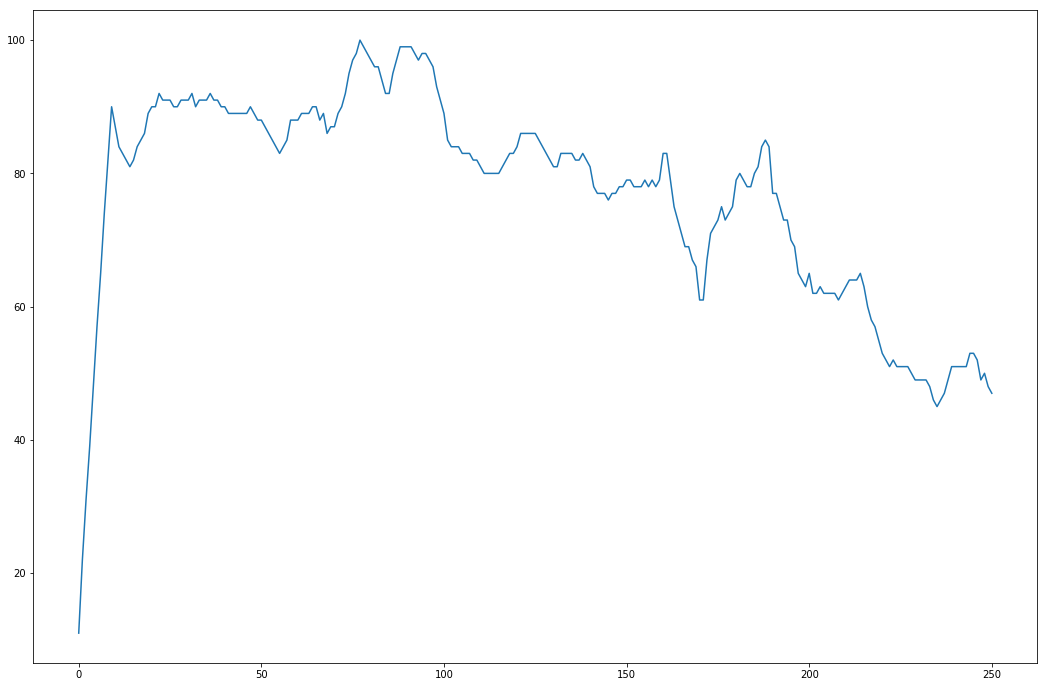

In [10]:
plt.figure(figsize=(18,12))
plt.plot(heatmapsumlist)